# Fragrance Recommendation System

This notebook allows you to get **fragrance recommendations based on images and text**.  
Upload an image, select your preferences, and receive perfume recommendations.


In [ ]:
#!pip install pandas numpy scikit-learn opencv-python rembg streamlit


## Import Modules

In [1]:
import os
import pandas as pd
from fragrance_code.data_loader import load_data
from fragrance_code.recommender_image_based import recommend_fragrances
from fragrance_code.model_text import train_model
from fragrance_code.image_processing import remove_background, remove_faces, extract_top_colors, dominant_colors_to_tags

import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\celia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\celia\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Upload an Image for Color Analysis
You can skip this text if your intention is to get only a text-based recommendation

In [2]:
# Widget for uploading an image
upload = widgets.FileUpload(accept='.jpg,.jpeg,.png', multiple=False)
display(upload)


FileUpload(value={}, accept='.jpg,.jpeg,.png', description='Upload')

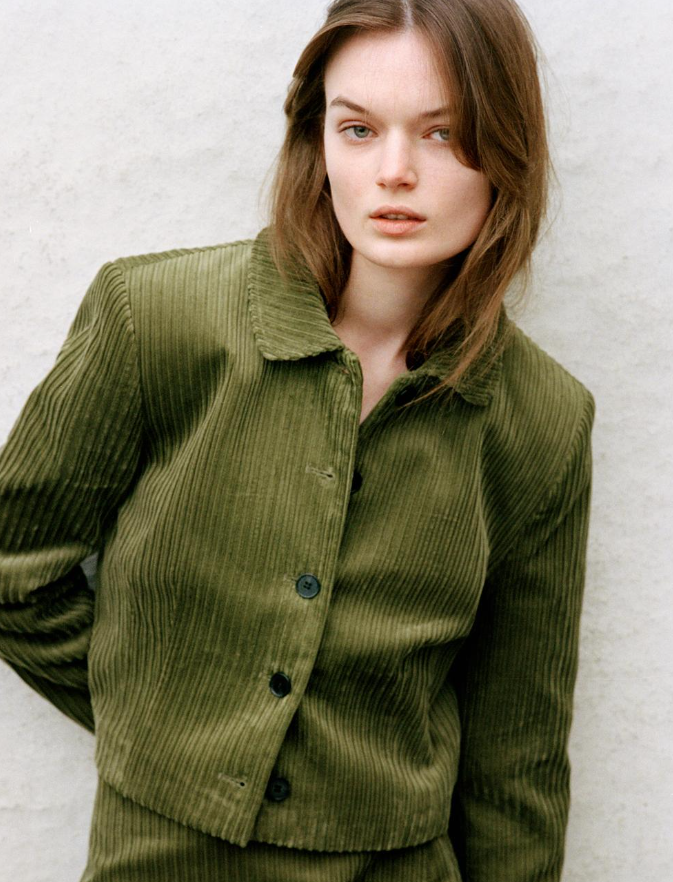

In [3]:
# Save the uploaded image as a temporary file
if upload.value:
    filename = list(upload.value.keys())[0]
    image_path = os.path.join("temp_uploaded_image.jpg")
    
    with open(image_path, "wb") as f:
        f.write(upload.value[filename]['content'])
    
    display(Image.open(image_path))
else:
    image_path = None


## Process Image and Detect Colors
Visualising the internal process of the functions to know the result of the image processing

Processing image...


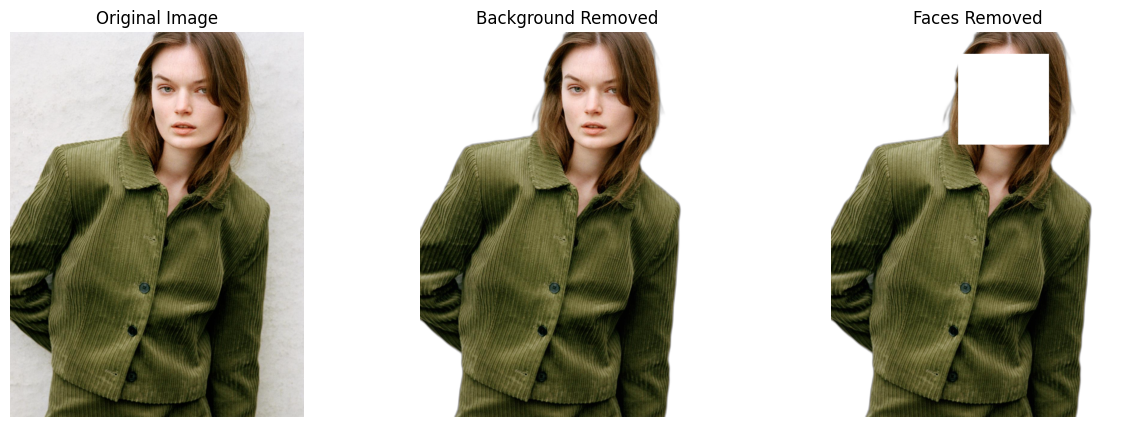

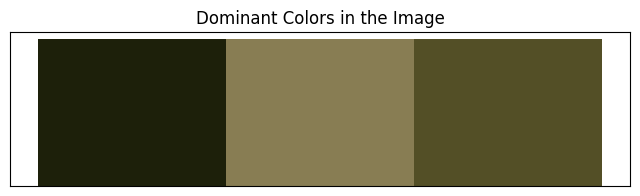

Detected Colors: ['Licorice', 'Dark Tan', 'Army Green']
Matching color tags: ['green', 'green', 'green']


In [4]:

if image_path:
    print("Processing image...")

    # Step 1: Remove background
    bg_removed_path = remove_background(image_path)
    
    # Step 2: Remove faces
    faces_removed_path = remove_faces(bg_removed_path)
    
    # Display images: original, background removed, and faces removed
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    original = Image.open(image_path)
    no_bg_image = Image.open(bg_removed_path)
    final_image = Image.open(faces_removed_path)
    
    ax[0].imshow(original)
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    
    ax[1].imshow(no_bg_image)
    ax[1].set_title("Background Removed")
    ax[1].axis("off")
    
    ax[2].imshow(final_image)
    ax[2].set_title("Faces Removed")
    ax[2].axis("off")
    
    plt.show()
    
    # Step 3: Extract dominant colors
    detected_colors = extract_top_colors(faces_removed_path)
    print(f"Detected Colors: {detected_colors}")


    # Step 4: Map the detected colors to their corresponding tags
    tagged_colors = dominant_colors_to_tags(detected_colors)
    print(f"Matching color tags: {tagged_colors}")


## Ensure model is trained

In [5]:
#Step 1: Ensure 'models/' Folder Exists
model_folder = "models/"
if not os.path.exists(model_folder):
    os.makedirs(model_folder)
    print(f"Created folder: {model_folder}")
else:
    print(f"Folder exists: {model_folder}")

#Step 2: Check if Model Files Exist
model_path = "models/tfidf_knn_model.pkl"
vectorizer_path = "models/vectorizer.pkl"

if os.path.exists(model_path) and os.path.exists(vectorizer_path):
    print("Pretrained model found. No need to retrain.")
else:
    print("Model files missing! Training a new model...")

    # **Load dataset**
    df = load_data()

    # **Ensure dataset has the required column**
    if df is None or "Olfactive Profile" not in df.columns:
        print("Error: Dataset does not contain the required column 'Olfactive Profile'.")
    else:
        # **Train and save the model**
        train_model(df, save_path="models/")
        print("Model training completed successfully!")


Folder exists: models/
Pretrained model found. No need to retrain.


## Select Preferences

In [6]:
# Load dataset to get unique brands
fragrance_df = load_data()
unique_brands = sorted(fragrance_df["Brand"].dropna().unique()) if fragrance_df is not None else []

Dataset loaded successfully!


In [7]:
# Widgets for Selecting Preferences
situation = widgets.Dropdown(
    options=["", "night", "casual", "romantic", "sport", "office"],
    description="Situation:"
)

gender = widgets.Dropdown(
    options=["", "male", "female", "unisex"],
    description="Gender:"
)

brand = widgets.Combobox(
    placeholder="Search or select a brand",
    description="Brand:",
    options=unique_brands,  # Populate with unique brand names
    ensure_option=True  # Ensures input is from the dropdown list
)

favorite_notes = widgets.Text(
    placeholder="Favorite notes (comma-separated, optional)",
    description="Notes:"
)

exclude_notes = widgets.Text(
    placeholder="Notes to exclude (optional)",
    description="Exclude:"
)

num_recommendations = widgets.IntSlider(
    value=5, min=1, max=10, step=1, description="Recommendations:"
)

# **Step 2: Display the preference selection widgets**
display(situation, gender, brand, favorite_notes, exclude_notes, num_recommendations)

Dropdown(description='Situation:', options=('', 'night', 'casual', 'romantic', 'sport', 'office'), value='')

Dropdown(description='Gender:', options=('', 'male', 'female', 'unisex'), value='')

Combobox(value='', description='Brand:', ensure_option=True, options=('a dozen roses', 'a lab on fire', 'a n o…

Text(value='', description='Notes:', placeholder='Favorite notes (comma-separated, optional)')

Text(value='', description='Exclude:', placeholder='Notes to exclude (optional)')

IntSlider(value=5, description='Recommendations:', max=10, min=1)

## Generate Recommendations

In [10]:
# Define the Recommendation Button and Output Area
button = widgets.Button(description="Get Recommendations")
output = widgets.Output()

def on_button_clicked(b):
    """
    Handles the recommendation process when the button is clicked.
    - Loads the dataset.
    - Applies filters based on optional user input.
    - Calls `recommend_fragrances()` function.
    - Displays the results.
    """
    with output:
        clear_output(wait=True)
        print("Searching for recommendations...")

        # **Step 1: Load the fragrance dataset**
        df = load_data()
        if df is None or df.empty:
            print("Error: Unable to load the fragrance dataset.")
            return

        # **Step 2: Process User Inputs**

        # Convert favorite notes input into a list or None if empty
        favorite_notes_list = (
            [note.strip() for note in favorite_notes.value.split(",") if note.strip()]
            if favorite_notes.value.strip() else None
        )

        # Convert exclude notes input into a list or None if empty
        exclude_notes_list = (
            [note.strip() for note in exclude_notes.value.split(",") if note.strip()]
            if exclude_notes.value.strip() else None
        )

        # Handle empty brand input
        brand_input = brand.value.strip() if brand.value.strip() else None

        # Handle empty situation and gender selections
        situation_input = situation.value if situation.value else None
        gender_input = gender.value if gender.value else None


           # **Step 3: Handle Tagged Colors (If Applicable)**
        tagged_colors_input = None  # Default to None if no tagged colors are detected
        if "tagged_colors" in globals() and tagged_colors:
            tagged_colors_input = tagged_colors

        # **Step 4: Call the Recommendation Function**
        recommendations = recommend_fragrances(
            tagged_colors=tagged_colors_input,
            situation=situation_input,
            gender=gender_input,
            brand=brand_input,
            favorite_notes=favorite_notes_list,
            exclude_notes=exclude_notes_list,
            num_recommendations=num_recommendations.value
        )

        # **Step 5: Display Results**
        if recommendations and isinstance(recommendations, list):
            print("\nRecommended Fragrances:")
            for i, fragrance in enumerate(recommendations, start=1):
                print(f"{i}. {fragrance}")
        else:
            print("No matching fragrances found. Try adjusting filters.")

# **Step 6: Attach the function to the button click event**
button.on_click(on_button_clicked)

# **Step 7: Display the button and output area**
display(button, output)



Button(description='Get Recommendations', style=ButtonStyle())

Output()